Notas sobre modificaciones realizadas 2024-05-11:
- Se filtro `df_business`, donde col `is_open == 1` (ver notas explicativas en el block de codigo)
- En `df_business`, no se elimina la col `address` porque puede ser dato util para enlazar al dataset de Google
- En `df_attributes`, se fijo col `business_id` como el index, para su uso eficiente en BigQuery
- En `df_attributes`, col `attributes` se mantendra anidado al exportar a BigQuery (BQ maneja datos anidados con mas eficiencia vs. tener una columna por atributo)
- `df_checkin` se desanido usando metodo `explode()`, y se filtro por los `business_id` que estan en el `df_business` procesado
- Nota: en `df_user`, hay `user_id` repetidos!

In [19]:
from glob import glob
from ftfy import fix_text
import pandas as pd

In [2]:
# Opción que deshabilita el limite de columnas y filas mostradas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---
## Carga de data Yelp

In [3]:
# Path de los archivos no-procesados (formato parquet)
path_data = '../../data'

### `y-business.parquet`

In [3]:
df_business = pd.read_parquet(f'{path_data}/raw/y-business.parquet')

### `y-checkin.parquet`

In [ ]:
df_checkin = pd.read_parquet(f'{path_data}/raw/y-checkin.parquet')

### `y-tip.parquet`

In [4]:
df_tip = pd.read_parquet(f'{path_data}/raw/y-tip.parquet')

### `y-review.parquet`

In [4]:
# Crear lista de archivos en /data/raw/y-review/
review_parquets = glob(f'{path_data}/raw/y-review/*')
review_parquets

['../../data/raw/y-review/y-review_03.parquet',
 '../../data/raw/y-review/y-review_02.parquet',
 '../../data/raw/y-review/y-review_01.parquet']

In [5]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_review = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-review/
for p in review_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_review
    df_review = pd.concat([df_review, df], ignore_index=True)

In [7]:
df_review['date'].isna().any()

False

### `y-user.parquet`

In [ ]:
# Crear lista de archivos en /data/raw/y-user/
user_parquets = glob(f'{path_data}/raw/y-user/*')
user_parquets

In [ ]:
# Crear dataframe donde se unen los datos extraidos de parquet
df_user = pd.DataFrame()
# Iterar por cada parquet dentro de /data/raw/y-user/
for p in user_parquets:
    # Leer parquet
    df = pd.read_parquet(p)
    # Unir a df_user
    df_user = pd.concat([df_user, df], ignore_index=True)

---
---
## Análisis Exploratorio

---
### `df_business`

In [ ]:
# Revisar el dataset e imprimir las primeras filas
print(df_business.info())
df_business.sample()

Columna `is_open`: filtro

Esta columna inidca el estado operacional del negocio. Se filtra negocios que estan operando.

In [6]:
df_business['is_open'].value_counts()

is_open
1    119702
0     30649
Name: count, dtype: int64

In [7]:
df_business = df_business[df_business['is_open'] == 1]
df_business['is_open'].value_counts()

is_open
1    119702
Name: count, dtype: int64

Columna `categories`: typecasting y filtro

In [8]:
# Convertir columna 'categories' a tipo list
df_business['categories'] = df_business['categories'].apply(lambda x: x.replace(', ',',').split(',') if x else [])

In [9]:
# Dejar en el dataset solo la categoría 'Restaurants'
filtro_categoria = 'Restaurants'
df_business = df_business[df_business['categories'].apply(lambda x: filtro_categoria in x)]
df_business.shape

(34987, 14)

Filtro por estados 'DE', 'NJ', 'PA'

In [10]:
# Filtramos los datos a la región elegida
estados_filtro = ['DE', 'NJ', 'PA']
df_business = df_business[df_business['state'].isin(estados_filtro)]
df_business.shape

(10203, 14)

In [ ]:
# Revisar los datos nuevamente
df_business.info()

Solo tenemos algunos nulos en "attributes" y "hours", que por el momento no se van a rellenar, hasta decidir si estas columnas serán utilizadas para los análisis.

In [ ]:
# Revisar las columnas numéricas
df_business.describe()

No se observan valores erróneos, como latitud y longitud con signo invertido, o calificaciones fuera del intérvalo 1 a 5.

Por el momento se va a mantener como está, hasta decidir si alguna de las "keys" puede ser de utilidad para algún análisis, y en ese caso se prodecerá a desanidar los datos.

In [ ]:
# Revisar nombres de columnas
df_business.columns

#### Las siguientes columnas serán eliminadas:

addres: Se cuenta con los datos de latitud y longitud  
is_open: Se entiende que se refiere al momento de la extracción de los datos. Se cuenta con los horarios de apertura y cierre


In [11]:
# Eliminar las columnas antes mencionadas
#df_business.drop("address", axis=1, inplace=True)  # se mantiene para comparar con dataset Google
df_business.drop("is_open", axis=1, inplace=True)

#### SE VA A EXTRAER A UN NUEVO ARCHIVO EL CONTENIDO DE LA COLUMNA "attributes", y se va a eliminar la misma del dataset de "business"

In [12]:
# Crear un dataframe nuevo para los atributos
df_attributes = df_business[["business_id", "attributes"]]
# Drop a "attributes" del df de origen
df_business.drop("attributes", axis=1, inplace=True)

In [ ]:
# Fijar `business_id`` como el index de `df_business`
df_business.set_index("business_id", inplace=True)
# Fijar `business_id`` como el index de `df_attributes`
df_attributes.set_index("business_id", inplace=True)

In [ ]:
# Buscar la primera fila que tenga atributos y extraer el diccionario para usar las llaves en la creación de las columnas del dataframe
contador = 0
total = df_attributes.shape[0]
while contador < total:
    if type(df_attributes["attributes"][contador]) != dict:
        pass
    else:
        diccionario = df_attributes["attributes"][contador]
        break

    contador +=1

In [ ]:
diccionario.keys()

In [ ]:
for key in diccionario.keys():
    df_attributes[key] = "None"

In [ ]:
contador = 0
total = df_attributes.shape[0]
while contador < total:
    if type(df_attributes["attributes"][contador]) != dict:
        pass
    else:
        dicc = df_attributes["attributes"][contador]
        for key in dicc.keys():
            df_attributes[key][contador] = dicc[key][0]

    contador +=1

#### Exportacion datos limpios de Business

In [ ]:
df_business.to_parquet(f'{path_data}/y_business_CLEAN.parquet')
df_attributes.to_parquet(f'{path_data}/y_business_attrib_CLEAN.parquet')

---
### `df_checkin`

#### En principio no vamos a realizar análisis que incluyan la fecha y hora de ingreso de los usuarios al local. Este dataset no se va a utilizar, por lo que no se va a desanidar la columna de registros (date), ni se va a realizar ningún otro proceso sobre el mismo. Se observa de todos modos que el dataset no contiene valores nulos.

In [ ]:
# Revisar el dataset
print(df_checkin.info())
df_checkin.sample()

Flitramos por los `business_id` en `df_business` procesado

In [ ]:
filtro_id = df_business['business_id']
df_checkin = df_checkin[df_checkin['business_id'].isin(filtro_id)]
df_checkin.shape

Se desanida usando metodo `explode()`

In [ ]:
df_checkin.set_index('business_id', inplace=True)
df_checkin['date'] = df_checkin['date'].str.split(',')
df_checkin = df_checkin.explode('date')
df_checkin['date'] = pd.to_datetime(df_checkin['date'], format='mixed')
df_checkin.reset_index(inplace=True)
df_checkin.head(10)

#### Exportacion datos limpios de CheckIn

In [ ]:
df_checkin.to_parquet(f'{path_data}/y_checkin_CLEAN.parquet')

---
### `df_tip`

In [ ]:
# Revisar el dataset
print(df_tip.info())
df_tip.head()

In [ ]:
df_tip.describe()

Los datos no contienen nulos y están en el formato correcto.

In [ ]:
# Sacar los id de los locales elegidos en el dataset de Business
filtro_id = df_business["business_id"]
# Filtrar los tips
df_tip = df_tip[df_tip["business_id"].isin(filtro_id)]
df_tip.shape

#### Exportacion datos limpios de Tip

In [ ]:
df_tip.to_parquet(f'{path_data}/y_tip_CLEAN.parquet')

---
### `df_review`

#### Transformacion

In [13]:
df_review.shape

(6990280, 9)

In [14]:
# Sacar los id de los locales elegidos en el dataset de Business
filtro_id = df_business["business_id"]
# Filtrar los review
df_review = df_review[df_review["business_id"].isin(filtro_id)]
df_review.shape

(1138498, 9)

In [15]:
type(df_review.iloc[0]['date'])

str

In [16]:
# Typecasting de col `date`
df_review['date'] = pd.to_datetime(df_review['date'], format='mixed')

In [17]:
# Corrigir errores de decoding de texto, columna `text`
df_review['text'] = df_review['text'].apply(fix_text)

In [18]:
# Agregar col `name`, desde `df_business`
df_review = pd.merge(df_review, df_business[['business_id', 'name']], on='business_id', how='left')

# Fijar nueva columna `name` como la primer columna del df 
nom_col = df_review.pop('name')
df_review.insert(0, 'name', nom_col)

In [19]:
df_review['review_id'].duplicated().any()

False

In [22]:
df_review.sample()

,name,user_id,business_id,stars,useful,funny,cool,text,date
review_id,,,,,,,,,
olnOvUh4NQbGohritme22Q,Grand Hacienda,X3ZthrdL_nsKhR9C2VbTZA,EF5Fpofz71Fo_UqUpZUYBQ,1.0,0,0,0,"A piss-poor, inauthentic sodium bomb. Must get...",2019-05-28 02:03:58


In [21]:
df_review.set_index('review_id', inplace=True)

##### Exportacion datos limpios de Review

In [23]:
df_review.to_parquet(f'{path_data}/y_review_CLEAN.parquet')

#### Exploracion

In [ ]:
print('las columnas de business son:', df_business.columns)
print('las columnas de checkin son:', df_checkin.columns)
print('las columnas de tip son:', df_tip.columns)
print('las columnas de user son:', df_user.columns)

In [ ]:
df_review_filtrado = pd.read_parquet(r'/home/henry/PF/Henry_PF/data/raw/y-review_filtrado.parquet')

In [ ]:
print('las columnas de review_filtrado son:', df_review_filtrado.columns)

corroboramos la información de la columna state en las reviews de yelp:

In [ ]:
df_review_filtrado['state'].value_counts()

Se desea analizar la puntuación en estrellas por estado: 

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Agrupar por estado y puntuación de estrellas, y contar el número de reseñas
reseñas_por_estado = df_review_filtrado.groupby(['state', 'stars']).size().unstack(fill_value=0)

# Crear un gráfico de barras para visualizar las reseñas por estado y puntuación de estrellas
reseñas_por_estado.plot(kind='bar', figsize=(10, 6))
plt.title('Cantidad de Reseñas por Puntuación de Estrellas y Estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=45)
plt.legend(title='Puntuación de Estrellas')
plt.show()


Filtramos los restaurants de la cadena Darden en el DataFrame de business:

In [ ]:
# Nombres específicos a buscar
nombres_especificos = [
    'olive garden', 'longhorn steakhouse', 'yard house', 
    "ruth's chris steak house", "cheddar's scratch kitchen", 
    'the capital grille', 'seasons 52', "eddiev's", 
    'bahama breeze'
]

# Convertir los nombres a minúsculas para hacer la búsqueda insensible a mayúsculas y minúsculas
nombres_especificos = [nombre.lower() for nombre in nombres_especificos]

# Filtrar el DataFrame por los nombres específicos
df_filtrado_nombres = df_business[df_business['name'].str.lower().str.contains('|'.join(nombres_especificos), case=False)]

df_filtrado_nombres.head(2)

In [ ]:
# Contar la cantidad de negocios para cada nombre específico
conteo_por_nombre = df_filtrado_nombres['name'].value_counts()

# Mostrar los resultados
print(conteo_por_nombre)

In [ ]:
# Convertir los nombres a minúsculas para hacer la búsqueda insensible a mayúsculas y minúsculas
nombres_especificos = [nombre.lower() for nombre in nombres_especificos]

# Filtrar el DataFrame por los nombres específicos
df_filtrado_nombres = df_business[df_business['name'].str.lower().isin(nombres_especificos)]

# Agrupar por nombre, asumiendo que cada nombre tiene asociadas las mismas categorías
categorias_por_nombre = df_filtrado_nombres.groupby('name')['categories'].unique().reset_index()

# Mostrar los resultados de manera más legible
categorias_por_nombre


---
### `df_user`

In [ ]:
df_user.shape

In [ ]:
# Filtrar usuarios con reviews en los business de interes
filtro_users = df_review['user_id']
# Filtrar los review
df_user = df_user[df_user["user_id"].isin(filtro_users)]
df_user.shape

In [ ]:
df_user.sample()

In [ ]:
# Se descartar col `name`
df_user.drop('name', axis=1, inplace=True)

Typecasting de col `yelping_since`

In [ ]:
# Typecasting de col `date`
df_user['yelping_since'] = pd.to_datetime(df_user['yelping_since'], format='mixed')

Typecasting de col `friends`

In [ ]:
# Convertir columna 'friends' a tipo list
df_user['friends'] = df_user['friends'].apply(lambda x: x.replace(', ',',').split(',') if x != 'None' else [])

In [ ]:
df_user['user_id'].duplicated().any()

In [ ]:
## Existen duplicados user_id. No se puede fijar como index
#df_user.set_index('user_id', inplace=True)

#### Exportacion datos limpios de User

In [ ]:
df_user.to_parquet(f'{path_data}/y_user_CLEAN.parquet')

#### Exploracion

In [ ]:
df_user.head()

In [ ]:
df_user.info()

En primer lugar se descartan las columnas de cumplidos hacia los usuarios

In [ ]:
df_user_filtrado = df_user[['user_id','name', 'review_count', 'yelping_since',
       'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars']]

Se determinara si se tiene pasajeros sospechosos que con una cantidad apreciable de reseñas siempre puntuen con 5 o 1 estrella, que solo hayan hecho una reseña o que presenten nombres extraños. 

In [ ]:
#Condiciones de usuarios sospechosos
mask_1 = (df_user_filtrado.average_stars == 5) & (df_user_filtrado.review_count > 4)
mask_2 = (df_user_filtrado.average_stars == 1) & (df_user_filtrado.review_count > 4) # Estas dos primeras condiciones son para evitar reseñas fuertemente sesgadas positiva o negativamente
mask_3 = (df_user_filtrado.review_count == 1) #No se tomaran en cuenta usuarios que hayan escrito una unica reseña
mask_4 = (df_user_filtrado.name.str.len() <= 2) | df_user_filtrado.name.str.contains('\.')#Esto es para filtrar nombres extraños como los que presentan 1 o 2 letras o los que contienen puntos

#Se define un nuevo df sin los usuarios sospechosos
df_user_filtrado = df_user_filtrado[~(mask_1) & ~(mask_2) & ~(mask_3) & ~(mask_4)]


In [ ]:
print("Cantidad de usuarios luego de filtrar:", len(df_user_filtrado))
print("Cantidad de usuarios totales:", len(df_user))

A continuacion se  analizan las reviews de los usuario considerados como elite en algun año.

In [ ]:
df_user_elite = df_user_filtrado[(df_user_filtrado.elite.notna()) & (df_user_filtrado.elite != "" )]
print("Cantidad de usuarios elite:", len(df_user_elite))

In [ ]:
df_user_filtrado[["review_count","average_stars"]].describe()


In [ ]:
df_user_elite[["review_count","average_stars"]].describe()

In [ ]:
# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


ax1.hist(df_user_filtrado.average_stars)
ax1.set_title('Histograma de puntuacion de los usuarios')
ax1.set_xlabel('Calificación Promedio')
ax1.set_ylabel('Numero de usuarios')


ax2.hist(df_user_elite.average_stars)
ax2.set_title('Usuarios de puntuacion de los usuarios elite')
ax2.set_xlabel('Calificación Promedio')
ax2.set_ylabel('Numero de usuarios')

# Ajustar diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Ambas distribuciones se encuentran sesgadas a la izquierda, sin embargo la del promedio de las puntuaciones de los usuarios elite se asemeja mucho mas a una distribucion normal. 

In [ ]:
def contar_amigos(friends):
    if friends == "None":
        return 0
    else:
        return len(friends.split(','))

df_user_elite['num_friends'] = df_user_elite['friends'].apply(contar_amigos)
df_user_filtrado['num_friends'] = df_user_filtrado['friends'].apply(contar_amigos)

Tambien es importante destacar que estos usuarios son mas influyentes, ya que presentan una mayor cantidad de fans y amigos. 

In [ ]:
# Crear una figura y ejes para los subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Graficar el primer histograma en el primer subgráfico
axs[0, 0].hist(df_user_filtrado[df_user_filtrado.num_friends < 2000].num_friends)
axs[0, 0].set_title('Histograma del numero de amigos por usuario')
axs[0, 0].set_xlabel('Número de amigos')
axs[0, 0].set_ylabel('Número de usuarios')

# Graficar el segundo histograma en el segundo subgráfico
axs[0, 1].hist(df_user_elite[df_user_elite.num_friends < 2000].num_friends)
axs[0, 1].set_title('Histograma del numero de amigos por usuario elite')
axs[0, 1].set_xlabel('Número de amigos')
axs[0, 1].set_ylabel('Número de usuarios')

# Graficar el tercer histograma en el tercer subgráfico
axs[1, 0].hist(df_user_elite[df_user_elite.fans < 300].fans)
axs[1, 0].set_title('Histograma del numero de fans por usuario elite')
axs[1, 0].set_xlabel('Número de fans')
axs[1, 0].set_ylabel('Número de usuarios')

# Graficar el cuarto histograma en el cuarto subgráfico
axs[1, 1].hist(df_user_filtrado[df_user_filtrado.fans < 300].fans)
axs[1, 1].set_title('Histograma del numero de fans por usuario')
axs[1, 1].set_xlabel('Número de fans')
axs[1, 1].set_ylabel('Número de usuarios')

# Ajustar espaciado entre subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

---

---
---
## Mapa

In [2]:
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

### Visualizacion de mapa

In [7]:
def crear_plot_mapa(df: pd.DataFrame) -> plt.Figure:
    """Devuelve una grafica tipo plt.Figure, con un Shapefile que
    presenta el territorio de USA, y el dataframe de entrada con
    columnas de coordinadas ('longitude', 'latitude').
    """
    # Descartar los nulos
    df = df.dropna(axis=0, subset=['longitude', 'latitude'])

    # Crear un GeoDataFrame con la data de coordinadas
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)

    # Cargar archivo shapefile
    mapa = gpd.read_file('../../assets/map_state_5m.shp')

    # Calculamos los limites del mapa
    minx, miny, maxx, maxy = gdf.total_bounds

    # Creamos los plots del mapa
    plt.figure()  # limpiar memory de plotly
    fig, ax = plt.subplots(figsize=(12, 10))
    mapa.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, marker='o', color='red', markersize=1)

    # Calculamos el margen del grafico
    margin_ratio = 0.5
    marginx = (maxx - minx) * margin_ratio
    marginy = (maxy - miny) * margin_ratio
    # Aplicamos los margenes en relacion a los plots en los extremos
    ax.set_xlim(minx - marginx, maxx + marginx)
    ax.set_ylim(miny - marginy, maxy + marginy)

    return plt

<Figure size 640x480 with 0 Axes>

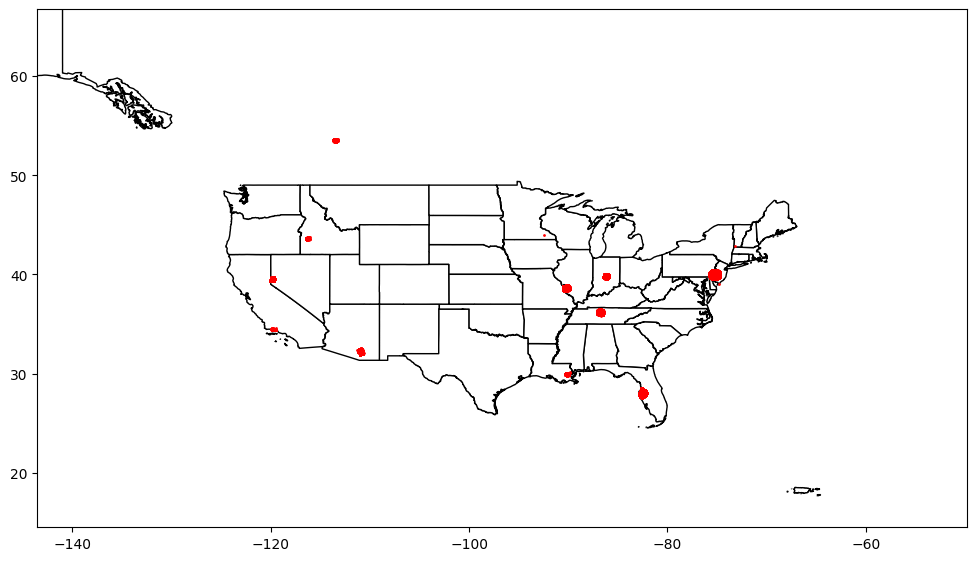

In [8]:
mapa_business = crear_plot_mapa(df_business_raw)
mapa_business.show()

### Mapa: area metropolitana de Philadelphia (PA, NJ, DE)

#### Outliers en `latitude` y `longitude`

In [ ]:
# Outliers en col `latitude`
plt.figure(figsize=(8, 2)) 
sns.boxplot(x=df_business['latitude'])
plt.show()

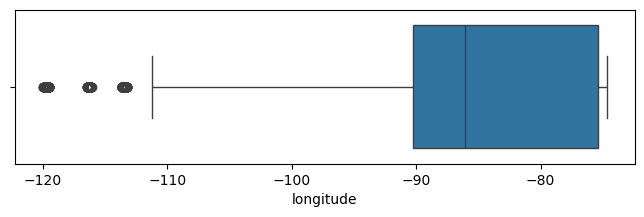

In [26]:
# Outliers en col `longitude`
plt.figure(figsize=(8, 2)) 
sns.boxplot(x=df_business['longitude'])
plt.show()

- Existen outliers, aun despues del dataframe `df_business` ser filtrado por estado (columna `state`)

#### Filtro de outliers

In [37]:
def es_dentro_de_area(latitude, longitude, punto_centro, radio=60) -> bool:
    """Devuelve valor boolean, True si `latitude` y `longitude` de entrada estan
    dentro del area definido por `punto_centro` y `radio. De lo contrario,
    devuelve False.
    """
    # Calcular la distancia desde el punto central `punto_centro`
    distancia = geodesic((latitude, longitude), punto_centro).miles
    # Check if the distance is within the specified radius
    return distancia <= radio

In [38]:
# TESTING - RAW
df_business = pd.read_parquet('../../data/raw/y-business.parquet')

Philadelphia

In [39]:
# Coordinadas de Philadelphia, PA
coord_philadelphia = (39.9526, -75.1652)

# Crear nuava columna con
df_business['es_area_Philadelphia'] = df_business.apply(lambda x: es_dentro_de_area(x['latitude'], x['longitude'], coord_philadelphia), axis=1)

Tampa

In [40]:
coord_tampa = (27.9475, -82.4586)

# Crear nuava columna con 
df_business['es_area_Tampa'] = df_business.apply(lambda x: es_dentro_de_area(x['latitude'], x['longitude'], coord_tampa), axis=1)

In [41]:
df_business[df_business['es_area_Philadelphia'] | df_business['es_area_Tampa']].shape[0]

71184

<Figure size 640x480 with 0 Axes>

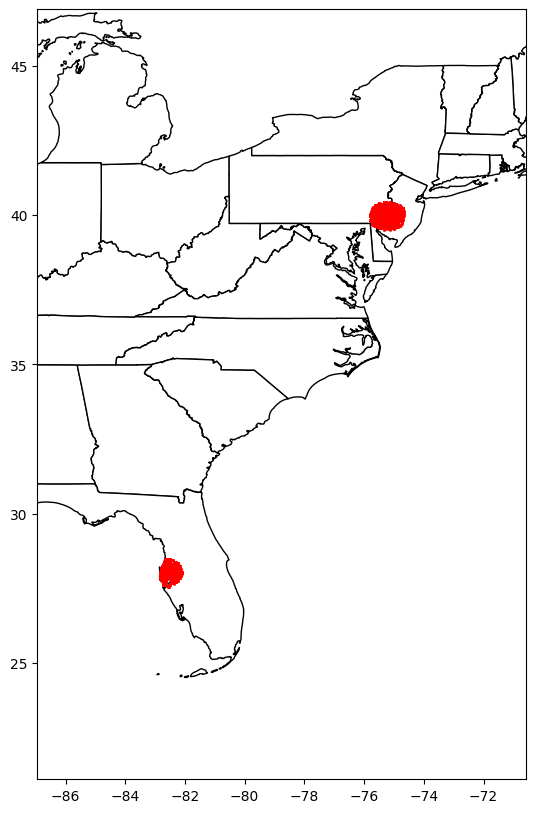

In [42]:
df_business_filtro_area = df_business[df_business['es_area_Philadelphia'] | df_business['es_area_Tampa']]

mapa_business_filtrado = crear_plot_mapa(df_business_filtro_area)
mapa_business.show()